In [2]:
spark

## O conjunto de dados foi baixado no [Portal da Transparência](http://www.portaltransparencia.gov.br/download-de-dados/viagens)

In [ ]:
### Para transformar o csv para o formato de UTF-8:
## rodar no terminal terminal: $ iconv -f ISO-8859-1 -t UTF-8 2019_Pagamento.csv > 2019_Pagamento_utf8.csv

In [33]:
PATH = "/home/broilo/Downloads/2019_20201025_Viagens/2019_Pagamento_utf8.csv"
PATH2 = "/home/broilo/Downloads/2019_20201025_Viagens/2019_Viagem_utf8.csv"

In [9]:
df = spark.read.csv(PATH, header=True, sep=";")

In [10]:
df.printSchema()

root
 |-- Identificador do processo de viagem: string (nullable = true)
 |-- Número da Proposta (PCDP): string (nullable = true)
 |-- Código do órgão superior: string (nullable = true)
 |-- Nome do órgão superior: string (nullable = true)
 |-- Codigo do órgão pagador: string (nullable = true)
 |-- Nome do órgao pagador: string (nullable = true)
 |-- Código da unidade gestora pagadora: string (nullable = true)
 |-- Nome da unidade gestora pagadora: string (nullable = true)
 |-- Tipo de pagamento: string (nullable = true)
 |-- Valor: string (nullable = true)



In [11]:
df.limit(5).toPandas()

,Identificador do processo de viagem,Número da Proposta (PCDP),Código do órgão superior,Nome do órgão superior,Codigo do órgão pagador,Nome do órgao pagador,Código da unidade gestora pagadora,Nome da unidade gestora pagadora,Tipo de pagamento,Valor
0,0000000000015045825,Sem informação,26000,Ministério da Educação,26291,Fundação Coordenação de Aperfeiçoamento de Pes...,154003,FUND.COORD.DE APERF.DE PESSOAL NIVEL SUPERIOR,PASSAGEM,"3406,33"
1,0000000000015100682,Sem informação,26000,Ministério da Educação,26291,Fundação Coordenação de Aperfeiçoamento de Pes...,154003,FUND.COORD.DE APERF.DE PESSOAL NIVEL SUPERIOR,PASSAGEM,"2925,83"
2,0000000000015114708,Sem informação,26000,Ministério da Educação,26291,Fundação Coordenação de Aperfeiçoamento de Pes...,154003,FUND.COORD.DE APERF.DE PESSOAL NIVEL SUPERIOR,PASSAGEM,"2760,02"
3,0000000000015163874,Sem informação,26000,Ministério da Educação,26291,Fundação Coordenação de Aperfeiçoamento de Pes...,154003,FUND.COORD.DE APERF.DE PESSOAL NIVEL SUPERIOR,PASSAGEM,"2875,92"
4,0000000000015166192,Sem informação,26000,Ministério da Educação,26291,Fundação Coordenação de Aperfeiçoamento de Pes...,154003,FUND.COORD.DE APERF.DE PESSOAL NIVEL SUPERIOR,PASSAGEM,"2420,48"


In [56]:
from pyspark.sql import functions as F
from pyspark.sql.types import FloatType

def to_value(v):
    try:
        return float(v.replace(",", "."))
    #except ValueError:
    except:
        return 0.0
udf_to_value = F.udf(to_value, FloatType())

In [16]:
df_typed = df.withColumn("Valor", udf_to_value(df["Valor"]))

In [17]:
df_typed.select("Nome do órgão superior", "Valor").limit(10).toPandas()

,Nome do órgão superior,Valor
0,Ministério da Educação,3406.330078
1,Ministério da Educação,2925.830078
2,Ministério da Educação,2760.020020
3,Ministério da Educação,2875.919922
4,Ministério da Educação,2420.479980
5,Ministério da Educação,1262.500000
6,Ministério da Educação,2694.580078
7,Ministério da Defesa,336.529999
8,Ministério da Defesa,666.679993
9,Ministério da Defesa,233.169998


In [22]:
pd = df_typed.groupBy("Nome do órgão superior") \
    .agg(F.sum("Valor").alias("Total")) \
    .orderBy("Total", ascending=False) \
    .toPandas()

In [23]:
pd

,Nome do órgão superior,Total
0,Ministério da Educação,2.202408e+08
1,Sigiloso,1.990554e+08
2,Ministério da Defesa,1.900550e+08
3,Ministério da Justiça e Segurança Pública,1.709973e+08
4,Ministério da Economia,1.385431e+08
5,Ministério da Saúde,6.463288e+07
6,Ministério do Meio Ambiente,4.511093e+07
7,"Ministério da Agricultura, Pecuária e Abasteci...",4.486405e+07
8,Ministério das Relações Exteriores,3.354079e+07
9,Ministério da Infraestrutura,3.353084e+07


In [24]:
pd = df_typed.groupBy("Nome do órgão superior") \
    .agg((F.sum("Valor") / F.lit(1_000_000)).alias("Total")) \
    .orderBy("Total", ascending=False) \
    .toPandas()

In [25]:
pd

,Nome do órgão superior,Total
0,Ministério da Educação,220.240791
1,Sigiloso,199.055358
2,Ministério da Defesa,190.055050
3,Ministério da Justiça e Segurança Pública,170.997329
4,Ministério da Economia,138.543055
5,Ministério da Saúde,64.632881
6,Ministério do Meio Ambiente,45.110931
7,"Ministério da Agricultura, Pecuária e Abasteci...",44.864054
8,Ministério das Relações Exteriores,33.540789
9,Ministério da Infraestrutura,33.530845


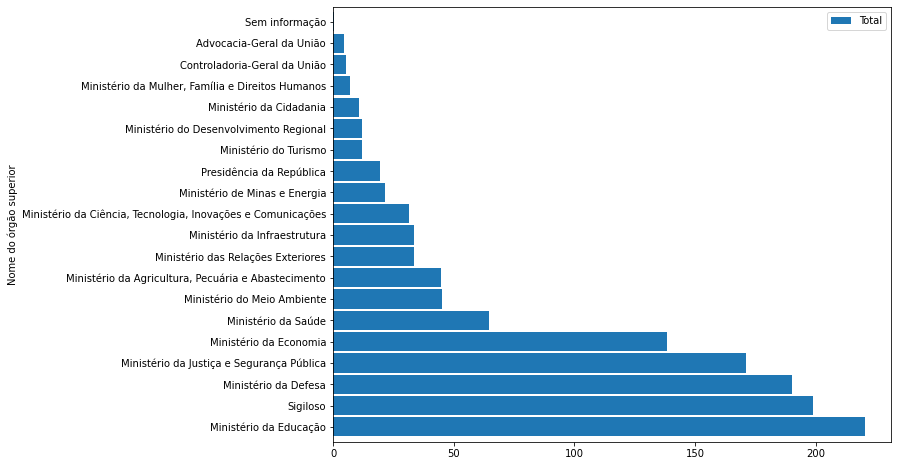

In [32]:
%matplotlib inline
pd.plot(kind="barh", x="Nome do órgão superior", figsize=[10, 8], width=0.9)

In [34]:
df2 = spark.read.csv(PATH2, header=True, sep=";")

In [35]:
df2.printSchema()

root
 |-- Identificador do processo de viagem: string (nullable = true)
 |-- Número da Proposta (PCDP): string (nullable = true)
 |-- Situação: string (nullable = true)
 |-- Viagem Urgente: string (nullable = true)
 |-- Justificativa Urgência Viagem: string (nullable = true)
 |-- Código do órgão superior: string (nullable = true)
 |-- Nome do órgão superior: string (nullable = true)
 |-- Código órgão solicitante: string (nullable = true)
 |-- Nome órgão solicitante: string (nullable = true)
 |-- CPF viajante: string (nullable = true)
 |-- Nome: string (nullable = true)
 |-- Cargo: string (nullable = true)
 |-- Função: string (nullable = true)
 |-- Descrição Função: string (nullable = true)
 |-- Período - Data de início: string (nullable = true)
 |-- Período - Data de fim: string (nullable = true)
 |-- Destinos: string (nullable = true)
 |-- Motivo: string (nullable = true)
 |-- Valor diárias: string (nullable = true)
 |-- Valor passagens: string (nullable = true)
 |-- Valor outros gast

In [36]:
df2.limit(5).toPandas()

,Identificador do processo de viagem,Número da Proposta (PCDP),Situação,Viagem Urgente,Justificativa Urgência Viagem,Código do órgão superior,Nome do órgão superior,Código órgão solicitante,Nome órgão solicitante,CPF viajante,...,Cargo,Função,Descrição Função,Período - Data de início,Período - Data de fim,Destinos,Motivo,Valor diárias,Valor passagens,Valor outros gastos
0,0000000000015045825,Sem informação,Realizada,NÃO,Sem informação,26000,Ministério da Educação,26291,Fundação Coordenação de Aperfeiçoamento de Pes...,***.377.624-**,...,None,-1,Não Informado,06/02/2019,07/02/2019,Recife/PE,Regresso de bolsista CAPES do exterior- PE ( P...,"0,00","3406,33","0,00"
1,0000000000015100682,Sem informação,Realizada,NÃO,Sem informação,26000,Ministério da Educação,26291,Fundação Coordenação de Aperfeiçoamento de Pes...,***.831.975-**,...,None,-1,Não Informado,01/02/2019,02/02/2019,Recife/PE,Capacitação PDSE (Programa de Doutorado Sanduí...,"0,00","2925,83","0,00"
2,0000000000015114708,Sem informação,Realizada,NÃO,Sem informação,26000,Ministério da Educação,26291,Fundação Coordenação de Aperfeiçoamento de Pes...,***.325.718-**,...,PESQUISADOR EM GEOCIENCIA,-1,Não Informado,01/02/2019,01/02/2019,São Paulo/SP,Capacitação no exterior - PDSE,"0,00","2760,02","0,00"
3,0000000000015163874,Sem informação,Realizada,NÃO,Sem informação,26000,Ministério da Educação,26291,Fundação Coordenação de Aperfeiçoamento de Pes...,***.003.005-**,...,PROFESSOR DO MAGISTERIO SUPERIOR,-1,Não Informado,17/02/2019,18/02/2019,Salvador/BA,Programa de Professor Visitante no Exterior - ...,"0,00","2875,92","0,00"
4,0000000000015166192,Sem informação,Realizada,NÃO,Sem informação,26000,Ministério da Educação,26291,Fundação Coordenação de Aperfeiçoamento de Pes...,***.660.311-**,...,TECNICO I,-1,Não Informado,20/02/2019,21/02/2019,Rio de Janeiro/RJ,Capacitação no exterior - PDSE.,"0,00","2420,48","0,00"


In [73]:
df2_typed = df2.withColumn("Valor passagens", udf_to_value(df2["Valor passagens"])) \
    .withColumn("Valor diárias", udf_to_value(df2["Valor diárias"])) \
    .withColumn("Valor outros gastos", udf_to_value(df2["Valor outros gastos"]))

In [74]:
df2_typed.select("Nome do órgão superior", "Valor passagens").limit(10).toPandas()

,Nome do órgão superior,Valor passagens
0,Ministério da Educação,3406.330078
1,Ministério da Educação,2925.830078
2,Ministério da Educação,2760.020020
3,Ministério da Educação,2875.919922
4,Ministério da Educação,2420.479980
5,Ministério da Educação,1262.500000
6,Ministério da Educação,2694.580078
7,Ministério da Defesa,1236.380005
8,Ministério da Defesa,746.349976
9,Ministério da Defesa,1293.410034


In [75]:
pd2 = df2_typed.groupBy("Nome", "CPF viajante") \
    .agg((F.sum("Valor passagens") / F.lit(1_000)).alias("ValorTotal")) \
    .orderBy("ValorTotal", ascending=False) \
    .limit(10) \
    .toPandas()

In [76]:
pd2

,Nome,CPF viajante,ValorTotal
0,Informações protegidas por sigilo,ID010900249,1065.545929
1,BENTO COSTA LIMA LEITE DE ALBUQUERQUE JUNIOR,***.593.277-**,335.785859
2,ROBERTO DE OLIVEIRA CAMPOS NETO,***.602.017-**,215.446949
3,DECIO FABRICIO ODDONE DA COSTA,***.112.110-**,208.874981
4,CARLOS ALEXANDRE JORGE DA COSTA,***.332.127-**,190.186081
5,Informações protegidas por sigilo,ID009400267,176.783139
6,LUIZ HENRIQUE MANDETTA,***.421.431-**,176.541891
7,CARLOS EDUARDO QUINTANILHA VAZ DE OLIVEIRA,***.493.141-**,165.803019
8,NISIA VERONICA TRINDADE LIMA,***.005.407-**,164.660520
9,PAULO ROBERTO SOARES PACHECO,***.137.867-**,156.802657


In [77]:
pd2 = df2_typed.groupBy("Nome", "CPF viajante") \
    .agg((F.sum("Valor passagens") / F.lit(1_000)).alias("ValorTotal")) \
    .filter("ValorTotal < 1000") \
    .orderBy("ValorTotal", ascending=False) \
    .limit(10) \
    .toPandas()

In [78]:
pd2

,Nome,CPF viajante,ValorTotal
0,BENTO COSTA LIMA LEITE DE ALBUQUERQUE JUNIOR,***.593.277-**,335.785859
1,ROBERTO DE OLIVEIRA CAMPOS NETO,***.602.017-**,215.446949
2,DECIO FABRICIO ODDONE DA COSTA,***.112.110-**,208.874981
3,CARLOS ALEXANDRE JORGE DA COSTA,***.332.127-**,190.186081
4,Informações protegidas por sigilo,ID009400267,176.783139
5,LUIZ HENRIQUE MANDETTA,***.421.431-**,176.541891
6,CARLOS EDUARDO QUINTANILHA VAZ DE OLIVEIRA,***.493.141-**,165.803019
7,NISIA VERONICA TRINDADE LIMA,***.005.407-**,164.660520
8,PAULO ROBERTO SOARES PACHECO,***.137.867-**,156.802657
9,PAULO ROBERTO NUNES GUEDES,***.305.876-**,151.715039


In [79]:
pd2 = df2_typed.groupBy("Nome", "CPF viajante") \
    .agg(((F.sum("Valor passagens") + F.sum("Valor diárias") + F.sum("Valor outros gastos")) / F.lit(1_000)) \
    .alias("ValorTotal")) \
    .filter("ValorTotal < 1000") \
    .orderBy("ValorTotal", ascending=False) \
    .limit(10) \
    .toPandas()

In [80]:
pd2

,Nome,CPF viajante,ValorTotal
0,BENTO COSTA LIMA LEITE DE ALBUQUERQUE JUNIOR,***.593.277-**,473.746800
1,DECIO FABRICIO ODDONE DA COSTA,***.112.110-**,325.460441
2,MARCOS CESAR PONTES,***.971.638-**,293.204193
3,PAULO ROBERTO SOARES PACHECO,***.137.867-**,289.159697
4,LUIZ HENRIQUE MANDETTA,***.421.431-**,280.300470
5,LUCAS PEDREIRA DO COUTO FERRAZ,***.350.278-**,279.949948
6,ROBERTO DE OLIVEIRA CAMPOS NETO,***.602.017-**,270.549879
7,THIAGO COUTO CARNEIRO,***.639.098-**,269.038618
8,ERIVALDO ALFREDO GOMES,***.969.471-**,267.698441
9,MAX WEBER MARQUES PEREIRA,***.731.241-**,262.905881


In [83]:
pd2 = df2_typed.groupBy("Nome", "CPF viajante") \
    .agg(((F.sum("Valor passagens") + F.sum("Valor diárias") + F.sum("Valor outros gastos")) / F.lit(1_000)) \
    .alias("ValorTotal"), \
        F.count("Valor passagens").alias("Quantidade")) \
    .filter("ValorTotal < 1000") \
    .orderBy("ValorTotal", ascending=False) \
    .limit(10) \
    .toPandas()

In [84]:
pd2

,Nome,CPF viajante,ValorTotal,Quantidade
0,BENTO COSTA LIMA LEITE DE ALBUQUERQUE JUNIOR,***.593.277-**,473.746800,70
1,DECIO FABRICIO ODDONE DA COSTA,***.112.110-**,325.460441,52
2,MARCOS CESAR PONTES,***.971.638-**,293.204193,54
3,PAULO ROBERTO SOARES PACHECO,***.137.867-**,289.159697,19
4,LUIZ HENRIQUE MANDETTA,***.421.431-**,280.300470,69
5,LUCAS PEDREIRA DO COUTO FERRAZ,***.350.278-**,279.949948,35
6,ROBERTO DE OLIVEIRA CAMPOS NETO,***.602.017-**,270.549879,40
7,THIAGO COUTO CARNEIRO,***.639.098-**,269.038618,22
8,ERIVALDO ALFREDO GOMES,***.969.471-**,267.698441,20
9,MAX WEBER MARQUES PEREIRA,***.731.241-**,262.905881,19


In [88]:
pd2 = df2_typed.groupBy("Nome do órgão superior", "Nome", "CPF viajante") \
    .agg(((F.sum("Valor passagens") + F.sum("Valor diárias") + F.sum("Valor outros gastos")) / F.lit(1_000)) \
    .alias("ValorTotal"), \
        F.count("Valor passagens").alias("Quantidade")) \
    .filter("Nome != 'Informações protegidas por sigilo'") \
    .orderBy("ValorTotal", ascending=False) \
    .limit(10) \
    .toPandas()

In [89]:
pd2

,Nome do órgão superior,Nome,CPF viajante,ValorTotal,Quantidade
0,Ministério de Minas e Energia,BENTO COSTA LIMA LEITE DE ALBUQUERQUE JUNIOR,***.593.277-**,473.746800,70
1,Ministério de Minas e Energia,DECIO FABRICIO ODDONE DA COSTA,***.112.110-**,325.460441,52
2,"Ministério da Ciência, Tecnologia, Inovações e...",MARCOS CESAR PONTES,***.971.638-**,293.204193,54
3,Ministério de Minas e Energia,PAULO ROBERTO SOARES PACHECO,***.137.867-**,289.159697,19
4,Ministério da Saúde,LUIZ HENRIQUE MANDETTA,***.421.431-**,280.300470,69
5,Ministério da Economia,ROBERTO DE OLIVEIRA CAMPOS NETO,***.602.017-**,270.549879,40
6,Ministério das Relações Exteriores,THIAGO COUTO CARNEIRO,***.639.098-**,269.038618,22
7,Ministério da Saúde,MAX WEBER MARQUES PEREIRA,***.731.241-**,262.905881,19
8,"Ministério da Agricultura, Pecuária e Abasteci...",TEREZA CRISTINA CORREA DA COSTA DIAS,***.694.306-**,259.060558,51
9,Ministério da Saúde,ANDRE PAES DE ALMEIDA,***.762.598-**,256.589331,18


In [97]:
df2_typed.filter((df2_typed["Nome"]=="BENTO COSTA LIMA LEITE DE ALBUQUERQUE JUNIOR") & \
                 (df2_typed["CPF viajante"]=="***.593.277-**")) \
    .withColumn("DataPartida", F.to_date(df2_typed["Período - Data de início"], format="dd/MM/yyyy")) \
    .toPandas()

,Identificador do processo de viagem,Número da Proposta (PCDP),Situação,Viagem Urgente,Justificativa Urgência Viagem,Código do órgão superior,Nome do órgão superior,Código órgão solicitante,Nome órgão solicitante,CPF viajante,...,Função,Descrição Função,Período - Data de início,Período - Data de fim,Destinos,Motivo,Valor diárias,Valor passagens,Valor outros gastos,DataPartida
0,0000000000015769629,Sem informação,Realizada,NÃO,Sem informação,32000,Ministério de Minas e Energia,32000,Ministério de Minas e Energia - Unidades com v...,***.593.277-**,...,-1,Não Informado,03/01/2019,07/01/2019,"Rio de Janeiro/RJ, São Paulo/SP",03/01 Presidir a solenidade de posse do Presid...,2479.419922,0.000000,842.450012,2019-01-03
1,0000000000015769668,Sem informação,Realizada,NÃO,Sem informação,32000,Ministério de Minas e Energia,32000,Ministério de Minas e Energia - Unidades com v...,***.593.277-**,...,-1,Não Informado,11/01/2019,14/01/2019,Rio de Janeiro/RJ,11/01 - Deslocamento para residência permanent...,0.000000,5246.729980,0.000000,2019-01-11
2,0000000000015772697,Sem informação,Realizada,NÃO,Sem informação,32000,Ministério de Minas e Energia,32000,Ministério de Minas e Energia - Unidades com v...,***.593.277-**,...,-1,Não Informado,17/01/2019,21/01/2019,Rio de Janeiro/RJ,18/01 - Reunião com o Ministro Paulo Guedes; e...,1390.040039,3260.560059,269.679993,2019-01-17
3,0000000000015783639,Sem informação,Realizada,NÃO,Sem informação,32000,Ministério de Minas e Energia,32000,Ministério de Minas e Energia - Unidades com v...,***.593.277-**,...,-1,Não Informado,24/01/2019,27/01/2019,"Rio de Janeiro/RJ, Belo Horizonte/MG",25/01 Reunião com ANP; Reunião e almoço com Dr...,1381.810059,1798.390015,0.000000,2019-01-24
4,0000000000015796185,Sem informação,Realizada,NÃO,Sem informação,32000,Ministério de Minas e Energia,32000,Ministério de Minas e Energia - Unidades com v...,***.593.277-**,...,-1,Não Informado,01/02/2019,04/02/2019,Rio de Janeiro/RJ,"Apresentação Institucional no CPRM, no Rio de...",269.679993,3280.560059,0.000000,2019-02-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,0000000000016711278,000989/19,Realizada,NÃO,Sem informação,32000,Ministério de Minas e Energia,32000,Ministério de Minas e Energia - Unidades com v...,***.593.277-**,...,CNE-0001,Cargo de Natureza Especial,28/11/2019,01/12/2019,Rio de Janeiro/RJ,Participar da premiação 'Personalidade do Ano'...,850.679993,2437.419922,0.000000,2019-11-28
66,0000000000016733919,001016/19-1C,Realizada,NÃO,Sem informação,32000,Ministério de Minas e Energia,32000,Ministério de Minas e Energia - Unidades com v...,***.593.277-**,...,CNE-0001,Cargo de Natureza Especial,18/12/2019,05/01/2020,"São Paulo/SP, Rio de Janeiro/RJ",- Participar da Cerimônia relativa aos Vencedo...,1381.810059,4108.319824,0.000000,2019-12-18
67,0000000000016772646,000812/19,Realizada,NÃO,Sem informação,32000,Ministério de Minas e Energia,32314,Empresa de Pesquisa Energética,***.593.277-**,...,-1,Não Informado,12/12/2019,16/12/2019,"Rio de Janeiro/RJ, Rio de Janeiro/RJ",Participar da 184ª Reunião do Conselho de Admi...,75.919998,2788.419922,0.000000,2019-12-12
68,0000000000016787460,001060/19,Realizada,NÃO,Sem informação,32000,Ministério de Minas e Energia,32000,Ministério de Minas e Energia - Unidades com v...,***.593.277-**,...,CNE-0001,Cargo de Natureza Especial,27/11/2019,27/11/2019,Altamira/PA,Participar de Cerimônia de Inauguração da Usin...,208.679993,0.000000,0.000000,2019-11-27


In [100]:
pd_gastador = df2_typed.filter((df2_typed["Nome"]=="BENTO COSTA LIMA LEITE DE ALBUQUERQUE JUNIOR") & \
                 (df2_typed["CPF viajante"]=="***.593.277-**")) \
    .withColumn("DataPartida", F.to_date(df2_typed["Período - Data de início"], format="dd/MM/yyyy")) \
    .groupBy(F.month("DataPartida").alias("MesPartida")) \
    .agg(((F.sum("Valor passagens") + F.sum("Valor diárias") + F.sum("Valor outros gastos")) / F.lit(1_000)) \
    .alias("ValorTotal"), \
        F.count("Valor passagens").alias("Quantidade")) \
    .orderBy("MesPartida") \
    .toPandas()

In [101]:
pd_gastador

,MesPartida,ValorTotal,Quantidade
0,1,16.669080,4
1,2,33.705290,6
2,3,45.847601,3
3,4,37.187930,8
4,5,66.464819,10
5,6,48.580069,6
6,7,15.781060,5
7,8,41.792761,5
8,9,34.323511,5
9,10,58.850930,7


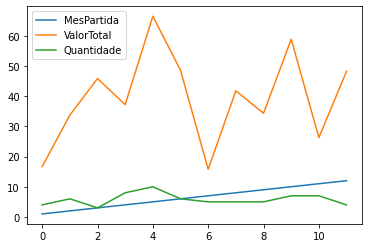

In [103]:
pd_gastador.plot(x="MesPartida")